# Проект оптимизации нефтедобычи

Цель - разработать модель для принятия решения о месте бурения новых скважин, исходя из максимальной прогнозируемой прибыли.  
Шаги для выбора локации:  
+ В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;  
+ Строят модель для предсказания объёма запасов в новых скважинах;  
+ Выбирают скважины с самыми высокими оценками значений;  
+ Определяют регион с максимальной суммарной прибылью отобранных скважин.  


# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
+ /datasets/geo_data_0.csv
+ /datasets/geo_data_1.csv 
+ /datasets/geo_data_2.csv  

Перечень признаков: 

+ id — уникальный идентификатор скважины;
+ f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
+ product — объём запасов в скважине (тыс. баррелей).

# Содержание проекта

[1. Загрузка и подготовка данных](#1)  

[2. Обучение и проверка модели](#2)
+ [Масштабирование признаков](#2.1)  
+ [Обучение модели](#2.2)  
+ [Вывод](#2_itog)  

[3. Подготовка к расчёту прибыли](#3)  
+ [Вывод](3_itog)  

[4. Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели](#4)  
+ [Вывод](4_itog)  

  
[5. Расчет прибыли и рисков для каждого региона](#5)  
+ [Вывод](4_itog) 

[Общий вывод](#itog)


# 1. Загрузка и подготовка данных <a id="1"></a>

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from scipy import stats as st
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

Изучим основную информацию:

In [3]:
display(geo_data_0.head())
display(geo_data_1.head())
display(geo_data_2.head())
display(geo_data_0.describe())
display(geo_data_1.describe())
display(geo_data_2.describe())
display(geo_data_0.info())
display(geo_data_1.info())
display(geo_data_2.info())


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

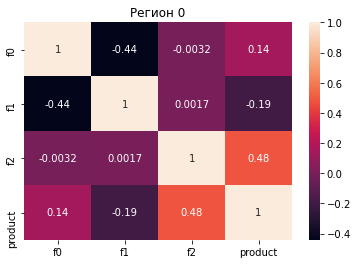

In [4]:
sns.heatmap(geo_data_0.corr(), annot = True)
plt.title('Регион 0')
plt.show()


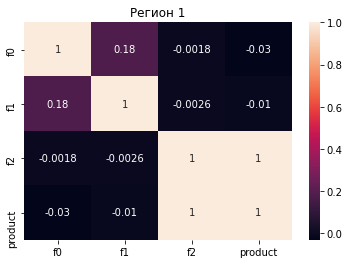

In [5]:
sns.heatmap(geo_data_1.corr(), annot = True)
plt.title('Регион 1')
plt.show()

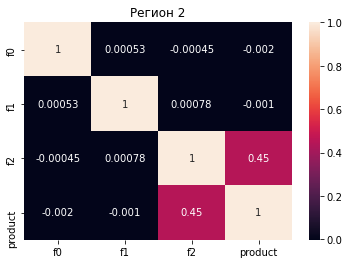

In [6]:
sns.heatmap(geo_data_2.corr(), annot = True)
plt.title('Регион 2')
plt.show()

Выделим признаки

In [7]:
features_0 = geo_data_0.drop('product', axis = 1)
target_0 = geo_data_0['product']
features_1 = geo_data_1.drop('product', axis = 1)
target_1 = geo_data_1['product']
features_2 = geo_data_2.drop('product', axis = 1)
target_2 = geo_data_2['product']

In [8]:
display(features_0.head())
display(features_1.head())
display(features_2.head())
display(target_0.head())
display(target_1.head())
display(target_2.head())

,id,f0,f1,f2
0,txEyH,0.705745,-0.497823,1.221170
1,2acmU,1.334711,-0.340164,4.365080
2,409Wp,1.022732,0.151990,1.419926
3,iJLyR,-0.032172,0.139033,2.978566
4,Xdl7t,1.988431,0.155413,4.751769


,id,f0,f1,f2
0,kBEdx,-15.001348,-8.276000,-0.005876
1,62mP7,14.272088,-3.475083,0.999183
2,vyE1P,6.263187,-5.948386,5.001160
3,KcrkZ,-13.081196,-11.506057,4.999415
4,AHL4O,12.702195,-8.147433,5.004363


,id,f0,f1,f2
0,fwXo0,-1.146987,0.963328,-0.828965
1,WJtFt,0.262778,0.269839,-2.530187
2,ovLUW,0.194587,0.289035,-5.586433
3,q6cA6,2.236060,-0.553760,0.930038
4,WPMUX,-0.515993,1.716266,5.899011


0    105.280062
1     73.037750
2     85.265647
3    168.620776
4    154.036647
Name: product, dtype: float64

0      3.179103
1     26.953261
2    134.766305
3    137.945408
4    134.766305
Name: product, dtype: float64

0     27.758673
1     56.069697
2     62.871910
3    114.572842
4    149.600746
Name: product, dtype: float64

### Вывод

Анализ входных данных показывает возможность проведения масштабирования признаков, что будет сделано далее.  
По матрицам корреляции видна существенная корреляционная связь между параметром f2 и целевым признаком. По региону 1 она и вовсе 100 % - ная.  
Это говорит о том, что фактически для моделирования мы могли бы обойтись одним этим столбцом, т.к. остальные параметры не оказывают существенного влияния на целевой признак.

# 2. Обучение и проверка модели <a id="2"></a>

Выделим обучающие и валидационные выборки:

In [9]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0,  test_size = 0.25, random_state = 12345)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1,  test_size = 0.25, random_state = 12345)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2,  test_size = 0.25, random_state = 12345)

In [10]:
display(features_train_0)

,id,f0,f1,f2
27212,sn8dh,0.022450,0.951034,2.197333
7866,oqj58,1.766731,0.007835,6.436602
62041,MaWjy,0.724514,0.666063,1.840177
70185,jyV1V,-1.104181,0.255268,2.026156
82230,g2kgI,-0.635263,0.747990,6.643327
...,...,...,...,...
4094,osNdz,1.863680,-0.298123,1.621324
85412,YFN4o,-1.162682,-0.014822,6.819941
2177,Ay91j,0.862688,-0.403776,1.867662
77285,MfaH6,0.846235,-0.489533,1.058786


### Масштабирование признаков <a id="2.1"></a>

In [11]:
warnings.filterwarnings("ignore")
numeric = ['f0', 'f1', 'f2']
scaler = StandardScaler()
scaler.fit(features_train_0[numeric])
scaler.fit(features_train_1[numeric])
scaler.fit(features_train_2[numeric])

features_train_0[numeric] = scaler.transform(features_train_0[numeric])
features_train_1[numeric] = scaler.transform(features_train_1[numeric])
features_train_2[numeric] = scaler.transform(features_train_2[numeric])
features_valid_0[numeric] = scaler.transform(features_valid_0[numeric])
features_valid_1[numeric] = scaler.transform(features_valid_1[numeric])
features_valid_2[numeric] = scaler.transform(features_valid_2[numeric])

In [12]:
display(features_train_0.head())

,id,f0,f1,f2
27212,sn8dh,0.010373,0.552230,-0.086690
7866,oqj58,1.017460,0.007459,1.134323
62041,MaWjy,0.415720,0.387637,-0.189559
70185,jyV1V,-0.640104,0.150370,-0.135993
82230,g2kgI,-0.369367,0.434956,1.193865


Установим идентификаторы скважин в качестве индексов.

In [13]:
features_train_0.set_index('id', inplace=True)
features_train_1.set_index('id', inplace=True)
features_train_2.set_index('id', inplace=True)
features_valid_0.set_index('id', inplace=True)
features_valid_1.set_index('id', inplace=True)
features_valid_2.set_index('id', inplace=True)
display(features_train_0.head())

,f0,f1,f2
id,,,
sn8dh,0.010373,0.552230,-0.086690
oqj58,1.017460,0.007459,1.134323
MaWjy,0.415720,0.387637,-0.189559
jyV1V,-0.640104,0.150370,-0.135993
g2kgI,-0.369367,0.434956,1.193865


### Обучение модели <a id="2.2"></a>

Создадим функцию обучения модели и расчет метрик:

In [14]:
def LinRegression(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid, prediction_valid)) ** 0.5
    r2 = r2_score(target_valid, prediction_valid)
    mae = mean_absolute_error(target_valid, prediction_valid)
    prediction_mean = pd.Series(prediction_valid).mean() # средний предсказанный объем запасов
    target_mean = pd.concat([target_valid, target_train]).mean() # средняя фактический объем запасов
    return rmse, prediction_mean, r2, mae, target_mean, prediction_valid


In [15]:
rmse_0, prediction_mean_0, r2_0, mae_0, target_mean_0, prediction_valid_0 = LinRegression(features_train_0, target_train_0, features_valid_0, target_valid_0)
rmse_1, prediction_mean_1, r2_1, mae_1, target_mean_1, prediction_valid_1 = LinRegression(features_train_1, target_train_1, features_valid_1, target_valid_1)
rmse_2, prediction_mean_2, r2_2, mae_2, target_mean_2, prediction_valid_2 = LinRegression(features_train_2, target_train_2, features_valid_2, target_valid_2)

In [16]:
metrics = {'RMSE': [rmse_0, rmse_1, rmse_2], 
        'MAE': [mae_0, mae_1, mae_2], 
        'R2': [r2_0, r2_1, r2_2], 
        'Ср. уровень запасов_модель': [prediction_mean_0, prediction_mean_1, prediction_mean_2],
        'Ср. уровень запасов_факт': [target_mean_0, target_mean_1, target_mean_2]
       }
metrics = pd.DataFrame(metrics)
display(metrics)

,RMSE,MAE,R2,Ср. уровень запасов_модель,Ср. уровень запасов_факт
0,37.579422,30.919601,0.279943,92.592568,92.500
1,0.893099,0.718766,0.999623,68.728547,68.825
2,40.029709,32.792652,0.205248,94.965046,95.000


В качестве эксперимента были рассчитаны метрики без масштабирование признаков - результаты аналогичны.

### Вывод <a id="2_itog"></a>

Были построены модели линейной регрессии для трех участков добычи.  
На текущем этапе, анализируя искомую метрику RMSE, можем сделать вывод, что модель линейной регрессии, построенная для первого участка добычи показывает наилучшие результаты. Данный участок дает минимальный уровень средней добычи в 68 тыс. баррелей.  
Модели для нулевого и второго участка показывают схожие результаты как по величине среднеквадратичной ошибки, так и по среднему уровню добычи в 92-94 тыс. баррелей.


# 3. Подготовка к расчету прибыли <a id="3"></a>

Отразим все исходные данные для расчетов в виде переменных и посчитаем точку безубыточности из расчета на одну скважину.

In [17]:
budget = 1e+10 #бюджет на разработку одного региона
holes = 500 # общее количество скважин для исследования
best_holes = 200 #лучшие скважины для разработки
barrel_price = 450e+3 # стоимость тысячи баррелей

Рассчитаем точку безубыточности для одной скважины как:  бюджет/кол-во скважин для разработки/стоимость тысячи баррелей

In [18]:
profit = budget / best_holes / barrel_price
print('%.2f' % profit)

111.11


Т.о., 111 тыс. баррелей - это минимальный запас нефти в одной скважине, который обеспечивает экономическую целесообразность для ее разработки, с допущением, что все скважины в рамках одного месторождения (региона) имеют одинаковый запас нефти.  
Сравним это с полученными ранее средними значениями запаса нефти в скважине (фактический и предсказанный).

In [19]:
display(metrics[['Ср. уровень запасов_модель', 'Ср. уровень запасов_факт']])

,Ср. уровень запасов_модель,Ср. уровень запасов_факт
0,92.592568,92.500
1,68.728547,68.825
2,94.965046,95.000


## Вывод

Проведенный анализ показывает, что средний уровень запасов по всем регионам меньше уровня безубыточности, равного 111 тыс. баррелей.  
Далее, реализуем функцию для выбора скважин с максимальным запасом нефти, что позволит обеспечить безубыточность разработки и рассчитаем размер потенциальной прибыли.

# 4. Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели <a id="4"></a>

In [20]:
prediction_valid_0 = pd.Series(prediction_valid_0)
prediction_valid_1 = pd.Series(prediction_valid_1)
prediction_valid_2 = pd.Series(prediction_valid_2)

In [21]:
target_valid_0 = target_valid_0.reset_index(drop = True)
target_valid_1 = target_valid_1.reset_index(drop = True)
target_valid_2 = target_valid_2.reset_index(drop = True)

In [23]:
def profit_(prediction_valid, target_valid, barrel_price, best_holes, budget):
    p1=prediction_valid.sort_values(ascending = False)
    t1=target_valid[p1.index][:best_holes]
    return t1.sum() * barrel_price - budget  

In [24]:
print('{:,.2f}'.format(profit(prediction_valid_0, target_valid_0, barrel_price, best_holes, budget)).replace(',', ' '))
print('{:,.2f}'.format(profit(prediction_valid_1, target_valid_1, barrel_price, best_holes, budget)).replace(',', ' '))
print('{:,.2f}'.format(profit(prediction_valid_2, target_valid_2, barrel_price, best_holes, budget)).replace(',', ' '))

3 320 826 043.14
2 415 086 696.68
2 710 349 963.60


## Вывод <a id="4_itog"></a>

Была создана функция расчета прибыли по скважинам, имеющим максимальный запас нефти, с использованием предсказаний модели.  
Полученные значения прибыли 3.2, 2.4, 2.7 млрд. руб., для регионов 0, 1, 2 соответственно, говорят о том, что использование 200 лучших скважин (с максимальными предсказанными запасами сырья), обеспечит большую прибыль в регионе 0).  
Далее проанализируем возможные риски и прибыль техникой Bootstrap, выберем регион с наибольшей средней прибылью.


# 5. Расчет рисков и прибыли для каждого региона<a id="5"></a>

Найдем распределение прибыли, применив технику Bootstrap с 1000 выборок

Средняя прибыль региона 0 : 425 938 526.91 руб.
2.5%-квантиль: 420 672 270.77 руб.
95%-ый доверительный интервал: (-102090094.83793654, 947976353.358369)
Количество отрицательных значений прибыли на 1000 выборок: 60
Вероятность убытков 6.00%


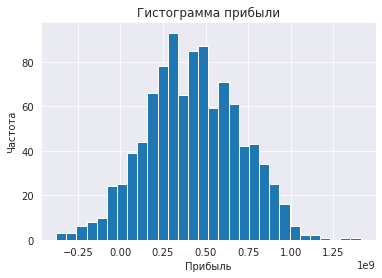

Средняя прибыль региона 1 : 518 259 493.70 руб.
2.5%-квантиль: 510 527 805.64 руб.
95%-ый доверительный интервал: (128123231.43308443, 953612982.0669085)
Количество отрицательных значений прибыли на 1000 выборок: 3
Вероятность убытков 0.30%


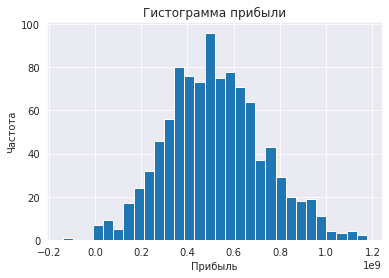

Средняя прибыль региона 2 : 420 194 005.34 руб.
2.5%-квантиль: 414 664 226.72 руб.
95%-ый доверительный интервал: (-115852609.16001143, 989629939.844574)
Количество отрицательных значений прибыли на 1000 выборок: 62
Вероятность убытков 6.20%


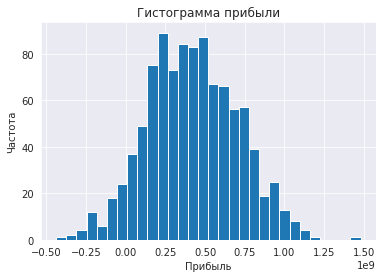

In [25]:
state = RandomState(12345) 

# списки переменных для использования в цикле
boot_target = [target_valid_0, target_valid_1, target_valid_2]
boot_predict = [prediction_valid_0, prediction_valid_1, prediction_valid_2]


values = []

for region in range(3): # Перебираем номера регионов
    for i in range(1000): #bootstrap
        target_subsample = boot_target[region].sample(n=500, replace=True, random_state=state)  
        probs_subsample = boot_predict[region][target_subsample.index]
        values.append(profit(probs_subsample, target_subsample, barrel_price, best_holes, budget)) 

    values = pd.Series(values)
    lower = values.quantile(0.5)
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))  # дов. интервал прогноза прибыли
    
    mean = values.mean()
    
    negativ_count = values[values < 0].count() # кол-во отрицательных значений прибыли
   
    print("Средняя прибыль региона", region, ": {:,.2f}".format(mean).replace(',', ' '), "руб.")
    print("2.5%-квантиль: {:,.2f}".format(lower).replace(',', ' '), "руб.")
    print("95%-ый доверительный интервал:", confidence_interval)
    print("Количество отрицательных значений прибыли на 1000 выборок:", negativ_count)
    print("Вероятность убытков {:.2%}".format(negativ_count / len(values)))
    
    
    sns.set_style('darkgrid')
    values.plot(kind = 'hist', bins = 30)
    plt.title('Гистограмма прибыли')
    plt.xlabel('Прибыль')
    plt.ylabel('Частота')
    plt.show()
    
    values = []
    

## Вывод <a id="5_itog"></a>

Расчеты показывают максимальную среднюю прибыль по региону 1, в размере 510 млн.руб. Этот регион также единственный показывает положительный 95% доверительный интервал.  
Оценивая риски убытков, было посчитано количество отрицательных значений прибыли для каждого региона и рассчитан уровень риска.
Регион 1 также показал минимальный уровень риска 0.3%. 
Остальные регионы, с уровнем риска более 6% не удовлетворяют условиям для дальнейшей разработки месторождений.
Гистрграммы дополнительно иллюстрируют полученные расчетные данные.

# Общий вывод<a id="itog"></a>

В рамках выполнения проекта, целью которого было определить оптимальные регионы для разработки нефти, были проведены следующие исследования:  
+ обучена модель линейной регрессии для каждого региона, получены предсказания по запасам сырья , рассчитаны основные метрики.
+ рассчитан минимальный уровень запаса сырья, равный 111 тыс. барр., обеспечивающий безубыточность разработки скважины.  
+ разработана функция расчета прибыли по предсказаняим модели линейной регрессии. На этом этапе определены потенциальные прибыли для каждого региона по 200 лучшим скважинам. 
+ расчитаны средние прибыли для каждого региона и риски убытков от разработки. Максимальную среднюю прибыль обеспечивает регион 1, с ее средним значением в 510 млн. руб.
+ вероятность убытков менее 2,5 % обеспечивает также только регион 1, добыча в прочих регионах не удовлетворяет условиям задачи по уровню требуемого риска.
    